In [ ]:
### Most important calculation from the calucalating returns and variable file #######

#crsp_data['day_return'] = (crsp_data['price_a'] / crsp_data['open_a']) - 1
#crsp_data['day_return_div'] = (crsp_data['price_div'] / crsp_data['open_a']) - 1
#crsp_data['night_return'] = (crsp_data['open_a'] / crsp_data['lag1_prc']) - 1
#crsp_data['night_return_div'] = (crsp_data['open_a'] / crsp_data['lag1_prc_div']) - 1

# Processing the Data

In [3]:
import pandas as pd

# Define transformation functions
def process_daynight_chunk(chunk):
    # Convert date and ensure data types are correct
    chunk['date'] = pd.to_datetime(chunk['date'])
    chunk['day_return_div'] = chunk['day_return_div'].astype('float32')
    chunk['night_return_div'] = chunk['night_return_div'].astype('float32')
    chunk.rename(columns={'day_return_div': 'day_ret', 'night_return_div': 'night_ret'}, inplace=True)
    #drop nan all columns
    chunk.dropna(axis=1, how='all', inplace=True)
    #drop day_return_div and night_return_div columns
    chunk.drop(columns=['MV','MV_o','day_ewretx','day_ewretd', 'night_ewretd', 'night_ewretx'], inplace=True)
    chunk.sort_values(by=['permno', 'date'], inplace=True)
    return chunk

def add_lags_leads(df, column_name, max_lags=5, max_leads=5):
    for i in range(1, max_lags + 1):
        df[f'lag_{i}_{column_name}'] = df.groupby('permno')[column_name].shift(i).astype('float32')
    for i in range(1, max_leads + 1):
        df[f'lead_{i}_{column_name}'] = df.groupby('permno')[column_name].shift(-i).astype('float32')
    return df

# Define the path and chunk size
file_path = r"C:\Users\gmarkari\Dropbox\David and Yann and Garen\Earnings Announcement and Day Night Returns\Data\Results from Garen day returns and index\daynight_returns.sas7bdat"
chunk_size = 50000

# Process SAS file in chunks
processed_chunks = []
for chunk in pd.read_sas(file_path, chunksize=chunk_size, iterator=True):
    processed_chunk = process_daynight_chunk(chunk)
    processed_chunk = add_lags_leads(processed_chunk, 'day_ret')
    processed_chunk = add_lags_leads(processed_chunk, 'night_ret')
    processed_chunks.append(processed_chunk)

# Concatenate all processed chunks into a single DataFrame
daynight = pd.concat(processed_chunks)
print(daynight.head())  # Optionally, print some of the processed data to verify

# You can now work with the 'daynight' DataFrame for further analysis or export


    permno       date  day_return   day_ret  night_return  night_ret  \
0  10001.0 1992-06-17    0.000000  0.000000     -0.020833  -0.020833   
1  10001.0 1992-06-18    0.000000  0.000000      0.000000   0.000000   
2  10001.0 1992-06-19    0.042553  0.042553      0.000000   0.000000   
3  10001.0 1992-07-01    0.000000  0.000000      0.000000   0.000000   
4  10001.0 1992-07-24    0.000000  0.000000      0.000000   0.000000   

   day_vwretx  day_vwretd  night_vwretx  night_vwretd  ...  lag_1_night_ret  \
0   -0.012258   -0.012253     -0.003307     -0.003409  ...              NaN   
1   -0.002551   -0.002533     -0.001706     -0.001712  ...        -0.020833   
2    0.004106    0.004128      0.002048      0.002030  ...         0.000000   
3    0.009526    0.009565      0.000290      0.000278  ...         0.000000   
4    0.003696    0.003711     -0.003917     -0.003945  ...         0.000000   

   lag_2_night_ret  lag_3_night_ret  lag_4_night_ret  lag_5_night_ret  \
0              NaN 

In [4]:
#drop day_return and night_return columns
daynight.drop(columns=['day_ret', 'night_ret'], inplace=True)

In [84]:
#shape of the data
print(daynight.shape)

(48767214, 28)


In [6]:
#drop nana on a differetn name
daynight_clean = daynight.dropna()

In [7]:
#print the shape of the cleaned data
print(daynight_clean.shape)

(48518316, 28)


In [8]:
#keep only the rows where a row has all the lags being not equal to 0
daynight_clean = daynight_clean[(daynight_clean[['lag_1_night_ret','lag_2_night_ret','lag_3_night_ret','lag_4_night_ret','lag_5_night_ret']] != 0).all(axis=1)]

#keep only the rows where a row has all the leads being not equal to 0
daynight_clean = daynight_clean[(daynight_clean[['lead_1_day_ret', 'lead_2_day_ret', 'lead_3_day_ret', 'lead_4_day_ret', 'lead_5_day_ret']] != 0).all(axis=1)]

#keep only the rows where a row has all the lags being not equal to 0
daynight_clean = daynight_clean[(daynight_clean[['lag_1_night_ret','lag_2_night_ret','lag_3_night_ret','lag_4_night_ret','lag_5_night_ret']] != 0).all(axis=1)]

#keep only the rows where a row has all the lead being not equal to 0
daynight_clean = daynight_clean[(daynight_clean[['lead_1_night_ret','lead_2_night_ret','lead_3_night_ret','lead_4_night_ret','lead_5_night_ret']] != 0).all(axis=1)]


In [9]:
#cleaned data shape
print(daynight_clean.shape)

(14609138, 28)


In [10]:
#drop day_vwretx day_vwretd night_vwretd night_vwretx columns
daynight_clean.drop(columns=['day_vwretx', 'day_vwretd', 'night_vwretd', 'night_vwretx'], inplace=True)

In [11]:
#day return to float 32 and night return to float 32
daynight_clean['day_return'] = daynight_clean['day_return'].astype('float32')
daynight_clean['night_return'] = daynight_clean['night_return'].astype('float32')

#convert permno day_ret and night_ret to float 32
daynight_clean['permno'] = daynight_clean['permno'].astype('int32')

In [12]:
#print types
print(daynight_clean.dtypes)

permno                      int32
date                datetime64[s]
day_return                float32
night_return              float32
lag_1_day_ret             float32
lag_2_day_ret             float32
lag_3_day_ret             float32
lag_4_day_ret             float32
lag_5_day_ret             float32
lead_1_day_ret            float32
lead_2_day_ret            float32
lead_3_day_ret            float32
lead_4_day_ret            float32
lead_5_day_ret            float32
lag_1_night_ret           float32
lag_2_night_ret           float32
lag_3_night_ret           float32
lag_4_night_ret           float32
lag_5_night_ret           float32
lead_1_night_ret          float32
lead_2_night_ret          float32
lead_3_night_ret          float32
lead_4_night_ret          float32
lead_5_night_ret          float32
dtype: object


In [13]:
ea_eanings_file = r"C:\Users\gmarkari\Dropbox\David and Yann and Garen\Earnings Announcement and Day Night Returns\Data\Files to run day returns and idex\EAsurprise.sas7bdat"

# Read the earnings announcement data
ea_data = pd.read_sas(ea_eanings_file)



In [14]:
# Show or export the earnings announcement data
print(ea_data.columns)

Index(['fiscalquarter', 'CONM', 'fiscalyear', 'assets', 'mktval', 'mb', 'ROA',
       'leverage', 'cal_yr', 'Altman', 'shareturnover', 'month', 'cal_qtr',
       'permno', 'CAR3dayEq', 'EAdate', 'rkmktval', 'ffindustry',
       'FFdescription', 'sue1', 'CFO', 'CFI', 'NUMEST', 'beat0', 'fail0',
       'surpriseP', 'dispP'],
      dtype='object')


In [15]:
#keep only the permno columns, surpriseP beat0 ffindustry EAdate
ea_data = ea_data[['permno', 'surpriseP', 'ffindustry', 'EAdate','leverage','mktval','cal_qtr','cal_yr']]

In [16]:
#drop nan
ea_data.dropna(inplace=True)

In [17]:
#print nan values
print(ea_data.isna().sum())

permno        0
surpriseP     0
ffindustry    0
EAdate        0
leverage      0
mktval        0
cal_qtr       0
cal_yr        0
dtype: int64


In [18]:
#print type
print(ea_data.dtypes)

permno              float64
surpriseP           float64
ffindustry          float64
EAdate        datetime64[s]
leverage            float64
mktval              float64
cal_qtr             float64
cal_yr              float64
dtype: object


In [19]:
#convert permno , surpriseP and ffindustry, sue1 leverage mkval cal_qtr cal_yr to float32
ea_data['permno'] = ea_data['permno'].astype('float32')
ea_data['surpriseP'] = ea_data['surpriseP'].astype('float32')
ea_data['ffindustry'] = ea_data['ffindustry'].astype('float32')
ea_data['leverage'] = ea_data['leverage'].astype('float32')
ea_data['mktval'] = ea_data['mktval'].astype('float32')
ea_data['cal_qtr'] = ea_data['cal_qtr'].astype('float32')
ea_data['cal_yr'] = ea_data['cal_yr'].astype('float32')








In [20]:
import pandas as pd


# Assuming 'date' in crsp_subset and 'EAdate' in ea_data, and both have 'permno'
merged_data = pd.merge(daynight_clean, ea_data, how='left', left_on=['date', 'permno'], right_on=['EAdate', 'permno'])

In [21]:
print(merged_data.shape)  # Optionally, print some of the merged data to verify

(14609138, 31)


In [22]:
import numpy as np

# The condition checks for non-zero and non-NaN values
merged_data['EA_earning_flag'] = np.where((merged_data['EAdate'].notna()) & (merged_data['EAdate'] != 0), 1, 0)

In [23]:
#count how mayne cells of ea earning flasg there is one
print(merged_data['EA_earning_flag'].sum())

102284


In [24]:
#shape of the data
print(merged_data.shape)

(14609138, 32)


In [25]:
#print the head
print(merged_data.head())

   permno       date  day_return  night_return  lag_1_day_ret  lag_2_day_ret  \
0   10001 2001-10-25   -0.003565      0.000261       0.026243      -0.029388   
1   10001 2001-10-26    0.000760     -0.012008      -0.003565       0.026243   
2   10001 2001-10-29    0.000217      0.014784       0.000760      -0.003565   
3   10001 2001-10-30    0.014978     -0.013043       0.000217       0.000760   
4   10001 2001-10-31    0.013158     -0.010417       0.014978       0.000217   

   lag_3_day_ret  lag_4_day_ret  lag_5_day_ret  lead_1_day_ret  ...  \
0       0.004070       0.000000      -0.086957        0.000760  ...   
1      -0.029388       0.004070       0.000000        0.000217  ...   
2       0.026243      -0.029388       0.004070        0.014978  ...   
3      -0.003565       0.026243      -0.029388        0.013158  ...   
4       0.000760      -0.003565       0.026243       -0.007043  ...   

   lead_4_night_ret  lead_5_night_ret  surpriseP  ffindustry  EAdate  \
0         -0.010417 

In [26]:
#set by index date and permno
merged_data.set_index(['date', 'permno'], inplace=True)

#sort by date and permno
merged_data.sort_values(by=['permno', 'date'], inplace=True)


# OLS analysis

In [27]:
import statsmodels.api as sm

# Filter out rows where EA_flag is 0 (i.e., no earnings announcement)
data_no_ea = merged_data[merged_data['EA_earning_flag'] == 0]

# Define the predictor variables (lags) and the target variable (lead)
X_no_ea = data_no_ea[['lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'lag_3_day_ret', 'lag_3_night_ret', 'lag_4_day_ret', 'lag_4_night_ret', 'lag_5_day_ret', 'lag_5_night_ret']]
X_no_ea = sm.add_constant(X_no_ea)  # adding a constant
y_no_ea = data_no_ea['day_return']

# Fit the model
model_no_ea = sm.OLS(y_no_ea, X_no_ea).fit()
print(model_no_ea.summary())

                            OLS Regression Results                            
Dep. Variable:             day_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2608.
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        00:08:17   Log-Likelihood:             2.9075e+07
No. Observations:            14506854   AIC:                        -5.815e+07
Df Residuals:                14506843   BIC:                        -5.815e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.866e-06   8.58e-06     

OLS for lead return 1 without surpirseP

In [28]:
import statsmodels.api as sm

# Filter out rows where EA_flag is 0 (i.e., no earnings announcement)
data_no_ea = merged_data[merged_data['EA_earning_flag'] == 0]

# Define the predictor variables (lags) and the target variable (lead)
X_no_ea = data_no_ea[['day_return', 'night_return','lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'lag_3_day_ret', 'lag_3_night_ret', 'lag_4_day_ret', 'lag_4_night_ret', 'lag_5_day_ret', 'lag_5_night_ret']]
X_no_ea = sm.add_constant(X_no_ea)  # adding a constant
y_no_ea = data_no_ea['lead_1_day_ret']

# Fit the model
model_no_ea = sm.OLS(y_no_ea, X_no_ea).fit()
print(model_no_ea.summary())


                            OLS Regression Results                            
Dep. Variable:         lead_1_day_ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2524.
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        00:08:32   Log-Likelihood:             2.8306e+07
No. Observations:            14506854   AIC:                        -5.661e+07
Df Residuals:                14506841   BIC:                        -5.661e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0002   9.05e-06     

OLS for night return without SurpriseP

In [29]:
import statsmodels.api as sm

# Filter out rows where EA_flag is 0 (i.e., no earnings announcement)
data_no_ea = merged_data[merged_data['EA_earning_flag'] == 0]

# Define the predictor variables (lags) and the target variable (lead)
X_no_ea = data_no_ea[['day_return','lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'lag_3_day_ret', 'lag_3_night_ret', 'lag_4_day_ret', 'lag_4_night_ret', 'lag_5_day_ret', 'lag_5_night_ret']]
X_no_ea = sm.add_constant(X_no_ea)  # adding a constant
y_no_ea = data_no_ea['night_return']

# Fit the model
model_no_ea = sm.OLS(y_no_ea, X_no_ea).fit()
print(model_no_ea.summary())

                            OLS Regression Results                            
Dep. Variable:           night_return   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                 2.214e+04
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        00:08:46   Log-Likelihood:             3.5503e+07
No. Observations:            14506854   AIC:                        -7.101e+07
Df Residuals:                14506842   BIC:                        -7.101e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0006   5.51e-06    1

OLS for lead 1 WITH surpirseP

In [30]:
# Filter to include rows where EA_flag is 1 (i.e., earnings announcement present)
data_with_ea = merged_data[merged_data['EA_earning_flag'] == 1]

# Define the predictor variables (include SurpriseP if it's numerical)
X_with_ea = data_with_ea[['day_return', 'night_return','lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'lag_3_day_ret', 'lag_3_night_ret', 'lag_4_day_ret', 'lag_4_night_ret', 'lag_5_day_ret', 'lag_5_night_ret', 'surpriseP']]
X_with_ea = sm.add_constant(X_with_ea)  # adding a constant
y_with_ea = data_with_ea['lead_1_day_ret']

# Fit the model
model_with_ea = sm.OLS(y_with_ea, X_with_ea).fit()
print(model_with_ea.summary())


                            OLS Regression Results                            
Dep. Variable:         lead_1_day_ret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     55.95
Date:                Wed, 15 May 2024   Prob (F-statistic):          1.75e-146
Time:                        00:08:48   Log-Likelihood:             1.8684e+05
No. Observations:              102284   AIC:                        -3.737e+05
Df Residuals:                  102270   BIC:                        -3.735e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0002      0.000     

OLS for night return WITH supriseP

In [31]:
# Filter to include rows where EA_flag is 1 (i.e., earnings announcement present)
data_with_ea = merged_data[merged_data['EA_earning_flag'] == 1]

# Define the predictor variables (include SurpriseP if it's numerical)
X_with_ea = data_with_ea[['day_return', 'lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'lag_3_day_ret', 'lag_3_night_ret', 'lag_4_day_ret', 'lag_4_night_ret', 'lag_5_day_ret', 'lag_5_night_ret', 'surpriseP']]
X_with_ea = sm.add_constant(X_with_ea)  # adding a constant
y_with_ea = data_with_ea['night_return']

# Fit the model
model_with_ea = sm.OLS(y_with_ea, X_with_ea).fit()
print(model_with_ea.summary())

                            OLS Regression Results                            
Dep. Variable:           night_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     27.53
Date:                Wed, 15 May 2024   Prob (F-statistic):           2.52e-63
Time:                        00:08:48   Log-Likelihood:             1.4438e+05
No. Observations:              102284   AIC:                        -2.887e+05
Df Residuals:                  102271   BIC:                        -2.886e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0019      0.000     

NEW OLS other variables with ea for nighth ret

In [32]:
# Filter to include rows where EA_flag is 1 (i.e., earnings announcement present)
data_with_ea = merged_data[merged_data['EA_earning_flag'] == 1]

# Define the predictor variables (include SurpriseP if it's numerical)
X_with_ea = data_with_ea[['day_return','lag_2_day_ret', 'lag_2_night_ret', 'lag_1_day_ret', 'lag_1_night_ret', 'surpriseP','ffindustry','leverage','mktval','cal_qtr','cal_yr']]
X_with_ea = sm.add_constant(X_with_ea)  # adding a constant
y_with_ea = data_with_ea['night_return']

# Fit the model
model_with_ea = sm.OLS(y_with_ea, X_with_ea).fit()
print(model_with_ea.summary())



                            OLS Regression Results                            
Dep. Variable:           night_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     27.30
Date:                Wed, 15 May 2024   Prob (F-statistic):           9.13e-58
Time:                        00:08:48   Log-Likelihood:             1.4436e+05
No. Observations:              102284   AIC:                        -2.887e+05
Df Residuals:                  102272   BIC:                        -2.886e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0700      0.061     

In [34]:
#create a new data where we take only the surpirseP that are bigger than 0
data_surprise_positive = merged_data[merged_data['surpriseP'] > 0]

#print the shape of the data
print(data_surprise_positive.shape)

(62753, 30)


OLS for night return with positive surpirseP

In [35]:
# Filter to include rows where EA_flag is 1 (i.e., earnings announcement present)
#data_with_ea = merged_data[merged_data['EA_earning_flag'] == 1]

# Define the predictor variables (include SurpriseP if it's numerical)
X_with_ea = data_surprise_positive[['day_return','lag_2_day_ret', 'lag_2_night_ret', 'lag_1_day_ret', 'lag_1_night_ret', 'surpriseP','ffindustry','leverage','mktval','cal_qtr','cal_yr']]
X_with_ea = sm.add_constant(X_with_ea)  # adding a constant
y_with_ea = data_surprise_positive['night_return']

# Fit the model
model_with_ea = sm.OLS(y_with_ea, X_with_ea).fit()
print(model_with_ea.summary())

                            OLS Regression Results                            
Dep. Variable:           night_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     39.55
Date:                Wed, 15 May 2024   Prob (F-statistic):           4.51e-86
Time:                        00:08:55   Log-Likelihood:                 92111.
No. Observations:               62753   AIC:                        -1.842e+05
Df Residuals:                   62741   BIC:                        -1.841e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4649      0.074     

In [36]:
#create a new data where we take only the surpirseP that are bigger than 0
data_surprise_negative = merged_data[merged_data['surpriseP'] < 0]

#print the shape of the data
print(data_surprise_positive.shape)

(62753, 30)


OLS for night return WITH negative surpirseP

In [37]:
# Filter to include rows where EA_flag is 1 (i.e., earnings announcement present)
#data_with_ea = merged_data[merged_data['EA_earning_flag'] == 1]

# Define the predictor variables (include SurpriseP if it's numerical)
X_with_ea = data_surprise_negative[['day_return', 'lag_2_day_ret', 'lag_2_night_ret', 'lag_1_day_ret', 'lag_1_night_ret', 'surpriseP','ffindustry','leverage','mktval','cal_qtr','cal_yr']]
X_with_ea = sm.add_constant(X_with_ea)  # adding a constant
y_with_ea = data_surprise_negative['night_return']

# Fit the model
model_with_ea = sm.OLS(y_with_ea, X_with_ea).fit()
print(model_with_ea.summary())

                            OLS Regression Results                            
Dep. Variable:           night_return   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     38.06
Date:                Wed, 15 May 2024   Prob (F-statistic):           2.59e-82
Time:                        00:08:55   Log-Likelihood:                 42894.
No. Observations:               30206   AIC:                        -8.576e+04
Df Residuals:                   30194   BIC:                        -8.566e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.3405      0.115     

# Quartiles Analysis

### Positive SurpriseP

In [38]:
import pandas as pd

# Assume 'data_surprise_positive' has already been filtered to include only positive 'SurpriseP'
quantiles = data_surprise_positive['surpriseP'].quantile([0.25, 0.50, 0.75])

# Create categorical bins based on these quantiles
data_surprise_positive['SurpriseP_Quantile'] = pd.cut(data_surprise_positive['surpriseP'], 
                                                      bins=[0, quantiles[0.25], quantiles[0.50], 
                                                            quantiles[0.75], data_surprise_positive['surpriseP'].max()],
                                                      labels=['Q1', 'Q2', 'Q3', 'Q4'],
                                                      include_lowest=True)

# Group by the quantile categories and calculate the mean for specified columns
grouped_stats = data_surprise_positive.groupby('SurpriseP_Quantile')[[
    'night_return', 'lead_1_day_ret', 'lead_1_night_ret', 
    'lead_2_day_ret', 'lead_2_night_ret', 'lead_3_day_ret', 
    'lead_3_night_ret', 'lead_4_day_ret', 'lead_4_night_ret', 
    'lead_5_day_ret', 'lead_5_night_ret'
]].mean()

# Rename the columns for clarity as per the user's request
grouped_stats.columns = ['N0', 'D1', 'N1', 'D2', 'N2', 'D3', 'N3', 'D4', 'N4', 'D5', 'N5']

# Print the results
print(grouped_stats)

                          N0        D1        N1        D2        N2  \
SurpriseP_Quantile                                                     
Q1                  0.000980 -0.000468  0.000336  0.000324 -0.000462   
Q2                  0.009616  0.000244  0.000683  0.000129 -0.000602   
Q3                  0.019601  0.000612  0.001079  0.000832 -0.000193   
Q4                  0.031688  0.000521  0.002857  0.001366  0.001185   

                          D3        N3        D4        N4        D5        N5  
SurpriseP_Quantile                                                              
Q1                  0.000276  0.000053 -0.000031  0.000122  0.000391 -0.000036  
Q2                  0.000809 -0.000138  0.000366  0.000053  0.000602 -0.000110  
Q3                  0.000336  0.000054  0.000718  0.000124  0.000542 -0.000304  
Q4                  0.000297  0.000848  0.000769  0.000823  0.001051  0.000612  


C:\Users\gmarkari\AppData\Local\Temp\ipykernel_11824\2684419799.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_surprise_positive['SurpriseP_Quantile'] = pd.cut(data_surprise_positive['surpriseP'],
C:\Users\gmarkari\AppData\Local\Temp\ipykernel_11824\2684419799.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = data_surprise_positive.groupby('SurpriseP_Quantile')[[


In [39]:
#save it to excel
#grouped_stats.to_excel(r"C:\Users\gmarkari\Dropbox\David and Yann and Garen\Earnings Announcement and Day Night Returns\Data\Results from Garen day returns and index\grouped_stats3.xlsx")

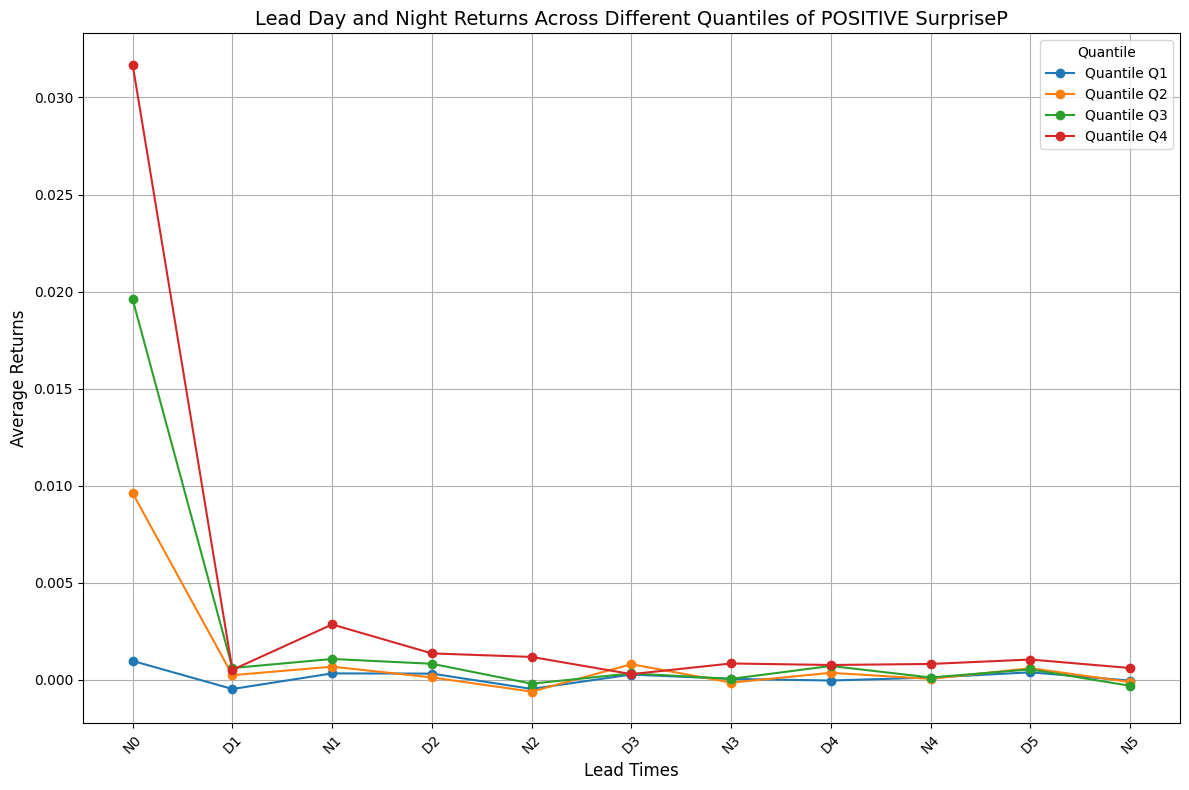

In [40]:
import matplotlib.pyplot as plt

# Create a line chart for each quantile showing the lead day and night returns
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each quantile's returns as a separate line in the graph
for quantile in grouped_stats.index:
    ax.plot(grouped_stats.columns, grouped_stats.loc[quantile], marker='o', label=f'Quantile {quantile}')

# Setting the plot title and labels
ax.set_title('Lead Day and Night Returns Across Different Quantiles of POSITIVE SurpriseP', fontsize=14)
ax.set_xlabel('Lead Times', fontsize=12)
ax.set_ylabel('Average Returns', fontsize=12)
ax.legend(title='Quantile')

# Improving layout for clarity
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### Negative SurpriseP

In [41]:
import pandas as pd

# Assuming 'merged_data' is your original DataFrame containing 'surpriseP'
# Filter to include only rows where 'SurpriseP' is negative
data_surprise_negative = merged_data[merged_data['surpriseP'] < 0]

# Calculate quantiles for 'surpriseP' in the filtered negative data
quantiles = data_surprise_negative['surpriseP'].quantile([0.25, 0.50, 0.75])

# Create categorical bins based on these quantiles
data_surprise_negative['SurpriseP_Quantile'] = pd.cut(data_surprise_negative['surpriseP'], 
                                                      bins=[data_surprise_negative['surpriseP'].min(), quantiles[0.25], quantiles[0.50], 
                                                            quantiles[0.75], 0],
                                                      labels=['Q1', 'Q2', 'Q3', 'Q4'],
                                                      include_lowest=True)

# Group by these quantile categories and calculate the mean for specified columns
grouped_stats = data_surprise_negative.groupby('SurpriseP_Quantile')[[
    'night_return', 'lead_1_day_ret', 'lead_1_night_ret', 
    'lead_2_day_ret', 'lead_2_night_ret', 'lead_3_day_ret', 
    'lead_3_night_ret', 'lead_4_day_ret', 'lead_4_night_ret', 
    'lead_5_day_ret', 'lead_5_night_ret'
]].mean()

# Rename the columns for clarity as per your request
grouped_stats.columns = ['N0', 'D1', 'N1', 'D2', 'N2', 'D3', 'N3', 'D4', 'N4', 'D5', 'N5']

# Print the results
print(grouped_stats)


                          N0        D1        N1        D2        N2  \
SurpriseP_Quantile                                                     
Q1                 -0.026484 -0.003801 -0.000892 -0.001137  0.001065   
Q2                 -0.026364 -0.000637 -0.001121  0.000018 -0.000273   
Q3                 -0.023136 -0.000154 -0.000841  0.000384 -0.000330   
Q4                 -0.017229 -0.000715 -0.000911  0.000319 -0.000260   

                          D3        N3        D4        N4        D5        N5  
SurpriseP_Quantile                                                              
Q1                 -0.001356  0.001736 -0.001656  0.001747 -0.001684  0.002113  
Q2                 -0.000377  0.000148 -0.000607  0.000206  0.001023 -0.000017  
Q3                 -0.000052 -0.000226 -0.000517  0.000082  0.001234 -0.000097  
Q4                  0.000432  0.000074  0.000060  0.000170  0.000615 -0.000137  


C:\Users\gmarkari\AppData\Local\Temp\ipykernel_11824\2736485975.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_surprise_negative['SurpriseP_Quantile'] = pd.cut(data_surprise_negative['surpriseP'],
C:\Users\gmarkari\AppData\Local\Temp\ipykernel_11824\2736485975.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = data_surprise_negative.groupby('SurpriseP_Quantile')[[


In [42]:
#save it to excel
#grouped_stats.to_excel(r"C:\Users\gmarkari\Dropbox\David and Yann and Garen\Earnings Announcement and Day Night Returns\Data\Results from Garen day returns and index\grouped_stats4.xlsx")

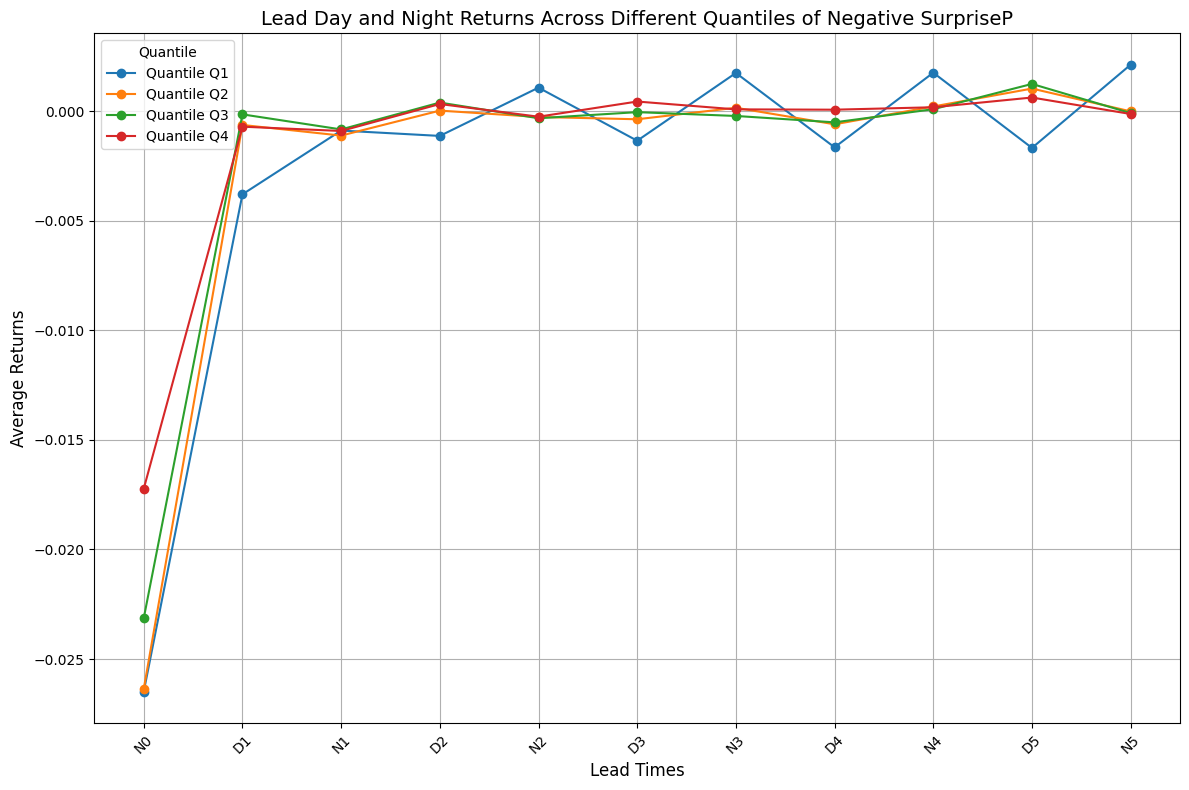

In [43]:
import matplotlib.pyplot as plt

# Assuming you have already run the previous code to generate 'grouped_stats' from negative surprises

# Create a line chart for each quantile showing the lead day and night returns
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each quantile's returns as a separate line in the graph
for quantile in grouped_stats.index:
    ax.plot(grouped_stats.columns, grouped_stats.loc[quantile], marker='o', label=f'Quantile {quantile}')

# Setting the plot title and labels
ax.set_title('Lead Day and Night Returns Across Different Quantiles of Negative SurpriseP', fontsize=14)
ax.set_xlabel('Lead Times', fontsize=12)
ax.set_ylabel('Average Returns', fontsize=12)
ax.legend(title='Quantile')

# Improving layout for clarity
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# Random Forest Model

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Filter the dataset
earnings_data = data_with_ea
non_earnings_data = data_no_ea

### Non earnings

#### Non earnings few variables initial model

In [45]:
#X_non_earnings = non_earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
#y_non_earnings = non_earnings_data[['night_return','lead_1_day_ret']]

# Random Forest model for non-earnings days
#model_non_earnings = RandomForestRegressor(n_estimators=100, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_non_earnings, y_non_earnings, test_size=0.2, random_state=42)
#model_non_earnings.fit(X_train, y_train)
#predictions = model_non_earnings.predict(X_test)
#mse_non_earnings = mean_squared_error(y_test, predictions)

#print(f'MSE for Non-Earnings Days: {mse_non_earnings}')

#### PCA Random Forest

In [46]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assume non_earnings_data is already loaded and structured
X_non_earnings = non_earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
y_non_earnings = non_earnings_data[['night_return','lead_1_day_ret']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_non_earnings)

# Apply PCA
pca = PCA(n_components=2)  # You may choose the number of components based on the variance explanation
X_pca = pca.fit_transform(X_scaled)

# Split the transformed data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_non_earnings, test_size=0.2, random_state=42)

# Random Forest model using PCA-transformed data
model_non_earnings = RandomForestRegressor(n_estimators=50, random_state=42)
model_non_earnings.fit(X_train, y_train)
predictions = model_non_earnings.predict(X_test)

# Calculate MSE
mse_non_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Non-Earnings Days: {mse_non_earnings}')


MSE for Non-Earnings Days: 0.0009430173545611742


#### First Model with arbitrary values

In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming non_earnings_data is already loaded and structured
X_non_earnings = non_earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
y_non_earnings = non_earnings_data[['night_return', 'lead_1_day_ret']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_non_earnings, y_non_earnings, test_size=0.2, random_state=42)

# Random Forest model with adjusted parameters
model_non_earnings = RandomForestRegressor(
    n_estimators=50,          # Reduce the number of trees
    max_depth=10,             # Limit the depth of each tree
    max_features='sqrt',      # Use sqrt of features at each split
    min_samples_split=5,      # Require at least 5 samples to split a node
    min_samples_leaf=4,       # Require at least 4 samples at a leaf node
    bootstrap=True,           # Use bootstrap samples
    random_state=42           # For reproducibility
)

# Fit the model
model_non_earnings.fit(X_train, y_train)

# Make predictions
predictions = model_non_earnings.predict(X_test)

# Calculate Mean Squared Error
mse_non_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Non-Earnings Days: {mse_non_earnings}')

# Calculate R-squared
r2_non_earnings = r2_score(y_test, predictions)
print(f'R-squared for Non-Earnings Days: {r2_non_earnings}')

MSE for Non-Earnings Days: 0.00082773832043384
R-squared for Non-Earnings Days: 0.016544295503242934


##### Grid Seach CV

In [86]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Assuming non_earnings_data is already loaded and structured
#X_non_earnings = non_earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
#y_non_earnings = non_earnings_data[['night_return']]

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_non_earnings, y_non_earnings, test_size=0.2, random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the RandomForestRegressor
#model_non_earnings = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
#grid_search = GridSearchCV(estimator=model_non_earnings, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
#grid_search.fit(X_train, y_train)

# Get the best parameters
#best_params = grid_search.best_params_

# Print the best parameters
#print(f'Best parameters found: {best_params}')


### Results  
best_params_non_ea = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 100
}

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pandas as pd

# Assuming non_earnings_data is already loaded and structured
X_non_earnings = non_earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
y_non_earnings = non_earnings_data['night_return']  # Assuming you want to predict 'night_return'

# Split the data into training and testing sets
X_train_non_ea, X_test_non_ea, y_train_non_ea, y_test_non_ea = train_test_split(X_non_earnings, y_non_earnings, test_size=0.2, random_state=42)

# Define the best parameters found from the hypertuning step for non-earnings model
best_params_non_ea = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 100
}

# Use the best parameters to train the non-earnings model
best_model_non_earnings = RandomForestRegressor(**best_params_non_ea, random_state=42)
best_model_non_earnings.fit(X_train_non_ea, y_train_non_ea)

# Make predictions
predictions_non_ea = best_model_non_earnings.predict(X_test_non_ea)

# Calculate the mean squared error
mse_non_ea = mean_squared_error(y_test_non_ea, predictions_non_ea)
print(f'MSE for Non-Earnings Days after hypertuning: {mse_non_ea}')

# Calculate R-squared
r2_non_ea = r2_score(y_test_non_ea, predictions_non_ea)
print(f'R-squared for Non-Earnings Days after hypertuning: {r2_non_ea}')

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Cross-validation for the hypertuned non-earnings model
cv_mse_non_ea = -cross_val_score(best_model_non_earnings, X_non_earnings, y_non_earnings, cv=5, scoring=mse_scorer).mean()
cv_r2_non_ea = cross_val_score(best_model_non_earnings, X_non_earnings, y_non_earnings, cv=5, scoring=r2_scorer).mean()

print(f'Cross-validated MSE: {cv_mse_non_ea}')
print(f'Cross-validated R²: {cv_r2_non_ea}')

# Append the results to a DataFrame
results_non_ea = pd.DataFrame({
    'Model': ['NO EARNINGS'],
    'MSE': [mse_non_ea],
    'R²': [r2_non_ea],
    'Cross-validated MSE': [cv_mse_non_ea],
    'Cross-validated R²': [cv_r2_non_ea]
})

# If you want to display or further use the DataFrame, here is how you can do it
print(results_non_ea)


KeyboardInterrupt: 

### EA without surpriseP

In [ ]:

# Assuming non_earnings_data is already loaded and structured
#X_earnings = earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
#y_earnings = earnings_data[['night_return', 'lead_1_day_ret']]

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Random Forest model with adjusted parameters
model_non_earnings = RandomForestRegressor(
    n_estimators=50,          # Reduce the number of trees
    max_depth=10,             # Limit the depth of each tree
    max_features='sqrt',      # Use sqrt of features at each split
    min_samples_split=5,      # Require at least 5 samples to split a node
    min_samples_leaf=4,       # Require at least 4 samples at a leaf node
    bootstrap=True,           # Use bootstrap samples
    random_state=42           # For reproducibility
)

# Fit the model
#model_non_earnings.fit(X_train, y_train)

# Make predictions
#predictions = model_non_earnings.predict(X_test)

# Calculate Mean Squared Error
#mse_non_earnings = mean_squared_error(y_test, predictions)
#print(f'MSE for Non-Earnings Days: {mse_non_earnings}')

# Calculate R-squared
#r2_non_earnings = r2_score(y_test, predictions)
#print(f'R-squared for Non-Earnings Days: {r2_non_earnings}')

KeyboardInterrupt: 

#### Param Grid CV

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare datasets
#X_earnings = earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
#y_earnings = earnings_data[['night_return', 'lead_1_day_ret']]

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RandomForestRegressor
#model_earnings = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
#grid_search = GridSearchCV(estimator=model_earnings, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
#grid_search.fit(X_train, y_train)

# Get the best parameters
#best_params = grid_search.best_params_

# Print the best parameters
#print(f'Best parameters found: {best_params}')


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
259 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


#### Results 
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pandas as pd

# Prepare datasets
X_earnings = earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']]
y_earnings = earnings_data[['night_return']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the best parameters found from the hypertuning step
best_params = {
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error
mse_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Earnings Days after hypertuning: {mse_earnings}')

# Calculate R-squared
r2_earnings = r2_score(y_test, predictions)
print(f'R-squared for Earnings Days after hypertuning: {r2_earnings}')

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Cross-validation for the hypertuned model
cv_mse = -cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=mse_scorer).mean()
cv_r2 = cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=r2_scorer).mean()

print(f'Cross-validated MSE: {cv_mse}')
print(f'Cross-validated R²: {cv_r2}')

# Append the results to a DataFrame
results_ea_without_surpriseP = pd.DataFrame({
    'Model': ['EA without SurpriseP'],
    'MSE': [mse_earnings],
    'R²': [r2_earnings],
    'Cross-validated MSE': [cv_mse],
    'Cross-validated R²': [cv_r2]
})

# If you want to display or further use the DataFrame, here is how you can do it
print(results_ea_without_surpriseP)



c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE for Earnings Days after hypertuning: 0.003624588863610791
R-squared for Earnings Days after hypertuning: 0.005291016860940689


c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# Saving feature importances
feature_importances_earnings = pd.DataFrame({
    'feature': X_earnings.columns,
    'importance': best_model_earnings.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort the features by importance
feature_importances_earnings = feature_importances_earnings.sort_values(by='importance', ascending=True)

# Plotting feature importances for the hypertuned EA model with `surpriseP`
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_earnings['feature'], feature_importances_earnings['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Features Importances in EA without SurpriseP')
plt.show()

### EA only with surpriseP

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100], #I took 100 because the previous one was 100 and I wanted to not redo the hypertuning for the number of n estimators
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\s

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pandas as pd

# Prepare datasets
X_earnings = earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret','surpriseP']]
y_earnings = earnings_data[['night_return']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the best parameters found from the hypertuning step
best_params = {
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error
mse_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Earnings Days after hypertuning: {mse_earnings}')

# Calculate R-squared
r2_earnings = r2_score(y_test, predictions)
print(f'R-squared for Earnings Days after hypertuning: {r2_earnings}')

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Cross-validation for the hypertuned model
cv_mse = -cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=mse_scorer).mean()
cv_r2 = cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=r2_scorer).mean()

print(f'Cross-validated MSE: {cv_mse}')
print(f'Cross-validated R²: {cv_r2}')

# Append the results to a DataFrame
results_ea_with_surpriseP = pd.DataFrame({
    'Model': ['EA with SurpriseP'],
    'MSE': [mse_earnings],
    'R²': [r2_earnings],
    'Cross-validated MSE': [cv_mse],
    'Cross-validated R²': [cv_r2]
})

# If you want to display or further use the DataFrame, here is how you can do it
print(results_ea_with_surpriseP)


MSE for Earnings Days after hypertuning: 0.002332199262494933
R-squared for Earnings Days after hypertuning: 0.06577052181940296
Cross-validated MSE: 0.002292250803424674
Cross-validated R²: 0.06387482461251644


In [ ]:
#change the name of the model to EA with SurpriseP
results_ea_with_surpriseP['Model'] = 'EA with SurpriseP'

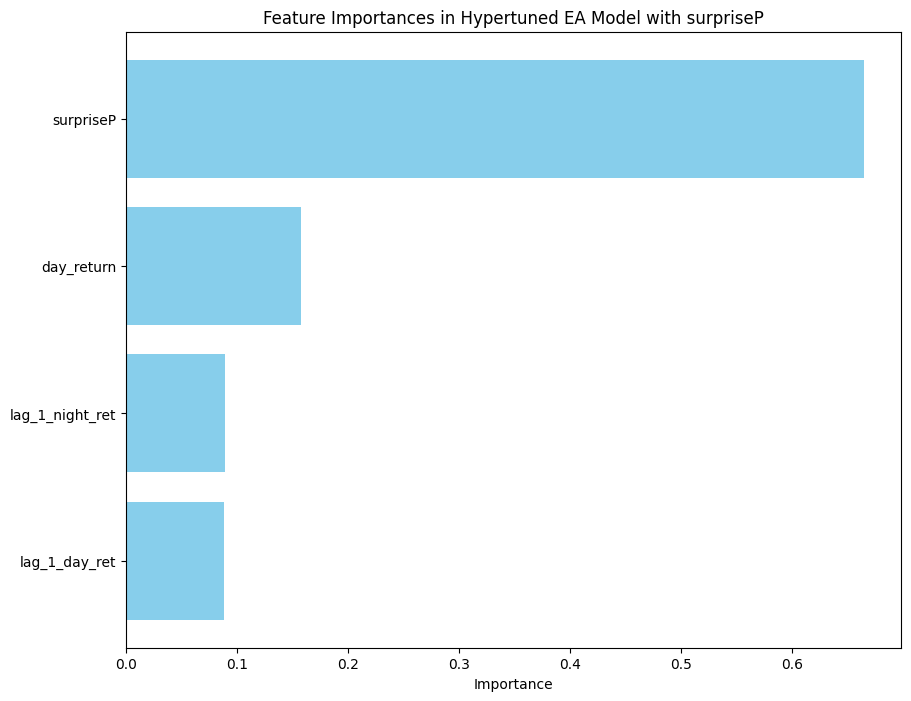

In [ ]:
# Saving feature importances
feature_importances_earnings = pd.DataFrame({
    'feature': X_earnings.columns,
    'importance': best_model_earnings.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort the features by importance
feature_importances_earnings = feature_importances_earnings.sort_values(by='importance', ascending=True)

# Plotting feature importances for the hypertuned EA model with `surpriseP`
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_earnings['feature'], feature_importances_earnings['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Features Importances in EA with SurpriseP')
plt.show()


### EA with more variables

In [56]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare datasets
X_earnings = earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret','surpriseP','ffindustry','leverage','mktval','cal_qtr','cal_yr']]
y_earnings = earnings_data[['night_return']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100], #I took 100 because the previous one was 100 and I wanted to not redo the hypertuning for the number of n estimators
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['sqrt']
}

# Initialize the RandomForestRegressor
model_earnings = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_earnings, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f'Best parameters found: {best_params}')

#Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

# Assuming best_params is already defined from the hypertuning step

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error
mse_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Earnings Days after hypertuning: {mse_earnings}')

# Calculate R-squared
r2_earnings = r2_score(y_test, predictions)
print(f'R-squared for Earnings Days after hypertuning: {r2_earnings}')

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Cross-validation for the hypertuned model
cv_mse = -cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=mse_scorer).mean()
cv_r2 = cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=r2_scorer).mean()

print(f'Cross-validated MSE: {cv_mse}')
print(f'Cross-validated R²: {cv_r2}')

#append the results to a data frarme whose name is the model name NON EARNINGS model
results_ea_with_surpriseP_with_variables = pd.DataFrame({'Model': ['EA without SurpriseP'], 'MSE': [mse_earnings], 'R²': [r2_earnings], 'Cross-validated MSE': [cv_mse], 'Cross-validated R²': [cv_r2]})



MSE for Earnings Days after hypertuning: 0.0023116627239271248
R-squared for Earnings Days after hypertuning: 0.07183259368033673
Cross-validated MSE: 0.0022724445946642738
Cross-validated R²: 0.07066281104742657


In [ ]:
#plot a usual graph after runnning a random forest model

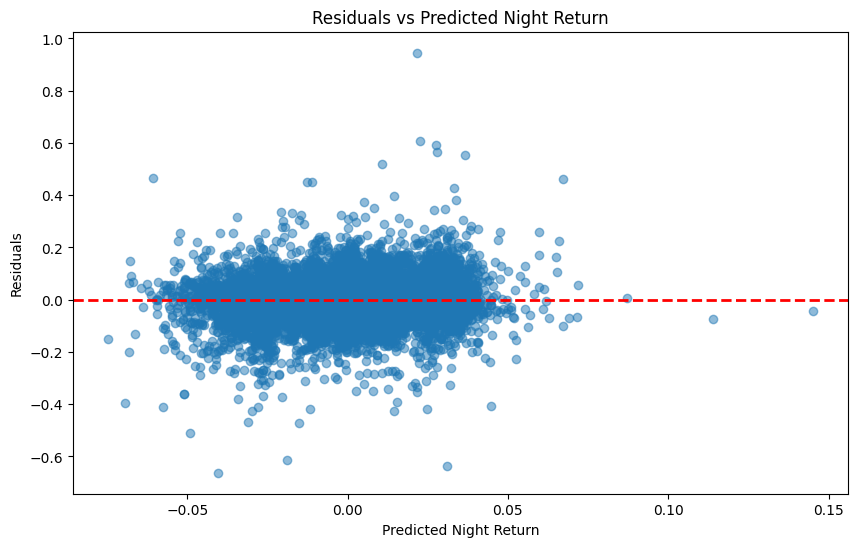

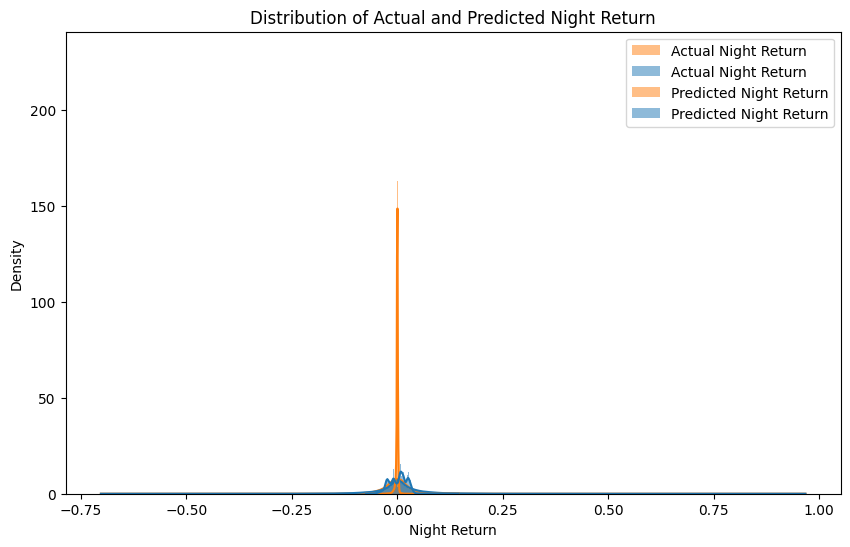

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Night Return')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Night Return')
plt.show()

# Distribution plot of actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Night Return', stat="density", linewidth=0)
sns.histplot(predictions, kde=True, color='orange', label='Predicted Night Return', stat="density", linewidth=0)
plt.xlabel('Night Return')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Night Return')
plt.legend()
plt.show()


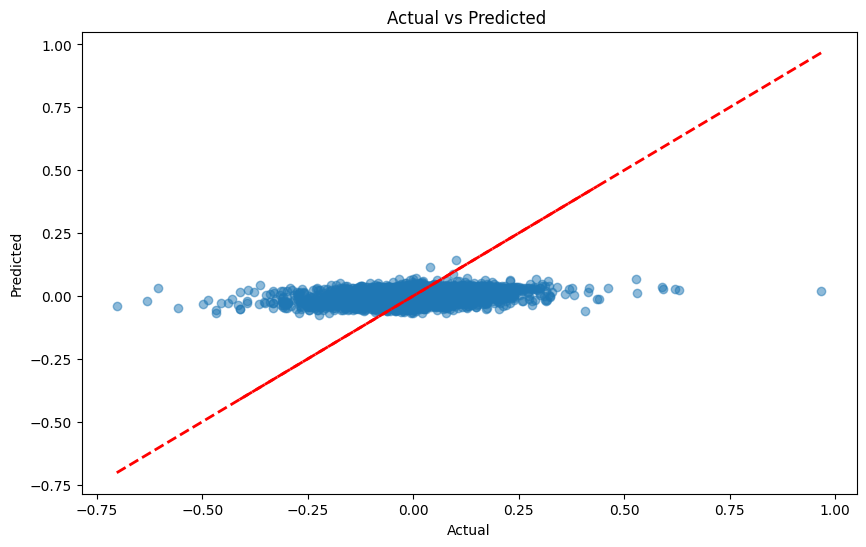

In [59]:
# Plotting Actual vs Predicted Night Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted ')
plt.show()

In [ ]:
#change the name of the model to EA with SurpriseP
results_ea_with_surpriseP_with_variables['Model'] = 'EA with SurpriseP with Variables'

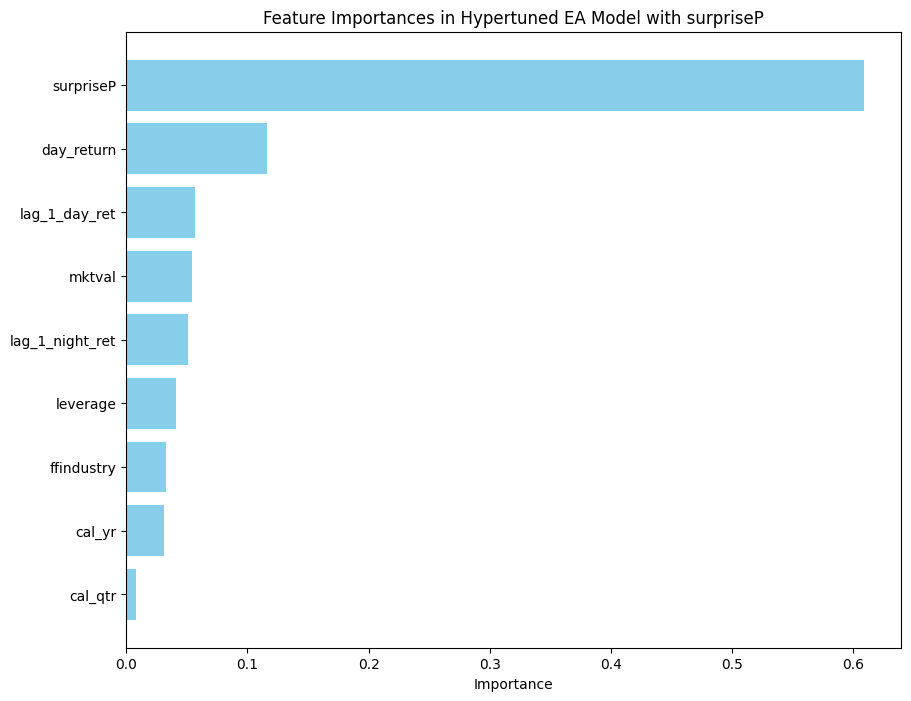

In [ ]:
# Saving feature importances
feature_importances_earnings = pd.DataFrame({
    'feature': X_earnings.columns,
    'importance': best_model_earnings.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort the features by importance
feature_importances_earnings = feature_importances_earnings.sort_values(by='importance', ascending=True)

# Plotting feature importances for the hypertuned EA model with `surpriseP`
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_earnings['feature'], feature_importances_earnings['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Features Importances in EA with many variables')
plt.show()


### Positive EA many variables

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare datasets
X_earnings = data_surprise_positive[['day_return', 'lag_1_day_ret', 'lag_1_night_ret','surpriseP','ffindustry','leverage','mktval','cal_qtr','cal_yr']]
y_earnings = data_surprise_positive[['night_return']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100], #I took 100 because the previous one was 100 and I wanted to not redo the hypertuning for the number of n estimators
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['sqrt']
}

# Initialize the RandomForestRegressor
model_earnings = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_earnings, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f'Best parameters found: {best_params}')

#Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

# Assuming best_params is already defined from the hypertuning step

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error
mse_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Earnings Days after hypertuning: {mse_earnings}')

# Calculate R-squared
r2_earnings = r2_score(y_test, predictions)
print(f'R-squared for Earnings Days after hypertuning: {r2_earnings}')

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Cross-validation for the hypertuned model
cv_mse = -cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=mse_scorer).mean()
cv_r2 = cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=r2_scorer).mean()

print(f'Cross-validated MSE: {cv_mse}')
print(f'Cross-validated R²: {cv_r2}')

#append the results to a data frarme whose name is the model name NON EARNINGS model
results_ea_with_surpriseP_positve = pd.DataFrame({'Model': ['EA without SurpriseP'], 'MSE': [mse_earnings], 'R²': [r2_earnings], 'Cross-validated MSE': [cv_mse], 'Cross-validated R²': [cv_r2]})



MSE for Earnings Days after hypertuning: 0.0021564225233740024
R-squared for Earnings Days after hypertuning: 0.03516226602147415
Cross-validated MSE: 0.002170487154844963
Cross-validated R²: 0.031125407030589292


In [ ]:
#change the name of the model to EA with SurpriseP
results_ea_with_surpriseP_positve['Model'] = 'EA positve with SurpriseP with variables'

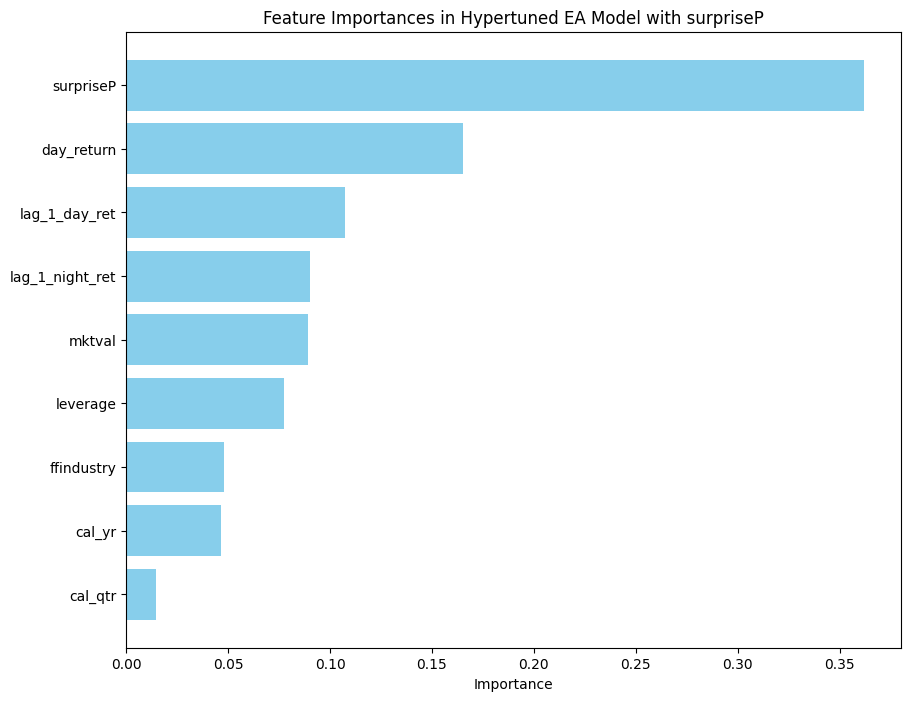

In [ ]:
# Saving feature importances
feature_importances_earnings = pd.DataFrame({
    'feature': X_earnings.columns,
    'importance': best_model_earnings.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort the features by importance
feature_importances_earnings = feature_importances_earnings.sort_values(by='importance', ascending=True)

# Plotting feature importances for the hypertuned EA model with `surpriseP`
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_earnings['feature'], feature_importances_earnings['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances EA Positive Model with surpriseP')
plt.show()


### Negative EA many variables

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare datasets
X_earnings = data_surprise_negative[['day_return', 'lag_1_day_ret', 'lag_1_night_ret','surpriseP','ffindustry','leverage','mktval','cal_qtr','cal_yr']]
y_earnings = data_surprise_negative[['night_return']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100], #I took 100 because the previous one was 100 and I wanted to not redo the hypertuning for the number of n estimators
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['sqrt']
}

# Initialize the RandomForestRegressor
model_earnings = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_earnings, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f'Best parameters found: {best_params}')

#Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

# Assuming best_params is already defined from the hypertuning step

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error
mse_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Earnings Days after hypertuning: {mse_earnings}')

# Calculate R-squared
r2_earnings = r2_score(y_test, predictions)
print(f'R-squared for Earnings Days after hypertuning: {r2_earnings}')

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Cross-validation for the hypertuned model
cv_mse = -cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=mse_scorer).mean()
cv_r2 = cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=r2_scorer).mean()

print(f'Cross-validated MSE: {cv_mse}')
print(f'Cross-validated R²: {cv_r2}')

#append the results to a data frarme whose name is the model name NON EARNINGS model
results_ea_with_surpriseP_negative = pd.DataFrame({'Model': ['EA without SurpriseP'], 'MSE': [mse_earnings], 'R²': [r2_earnings], 'Cross-validated MSE': [cv_mse], 'Cross-validated R²': [cv_r2]})

MSE for Earnings Days after hypertuning: 0.002606242235076426
R-squared for Earnings Days after hypertuning: 0.03337877448497106
Cross-validated MSE: 0.002551090642570899
Cross-validated R²: 0.03015612774278007


In [ ]:
#change the name of the model to EA with SurpriseP
results_ea_with_surpriseP_negative['Model'] = 'EA negative with SurpriseP with variables'

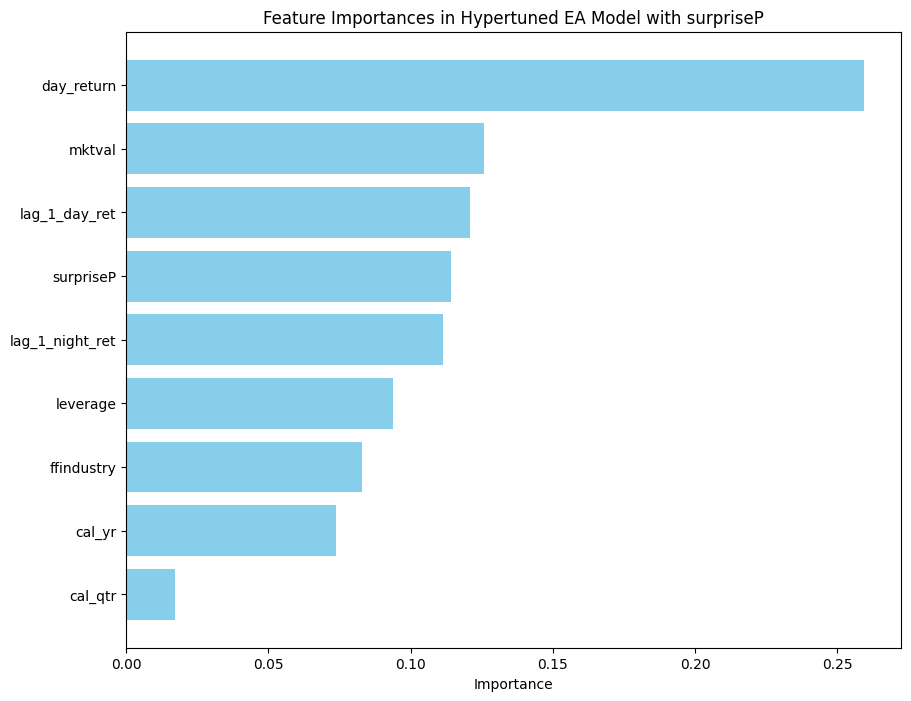

In [ ]:
# Saving feature importances
feature_importances_earnings = pd.DataFrame({
    'feature': X_earnings.columns,
    'importance': best_model_earnings.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort the features by importance
feature_importances_earnings = feature_importances_earnings.sort_values(by='importance', ascending=True)

# Plotting feature importances for the hypertuned EA model with `surpriseP`
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_earnings['feature'], feature_importances_earnings['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances EA Negative Model with surpriseP')
plt.show()

### Hypertuned EA positve Model

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
281 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages

Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pandas as pd

# Prepare datasets
X_earnings = data_surprise_positive[['day_return', 'lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret','lag_2_night_ret','surpriseP','ffindustry','leverage','mktval','cal_qtr','cal_yr']]
y_earnings = data_surprise_positive[['night_return']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the best parameters found from the hypertuning step
best_params = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 150
}

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error
mse_earnings = mean_squared_error(y_test, predictions)
print(f'MSE for Earnings Days after hypertuning: {mse_earnings}')

# Calculate R-squared
r2_earnings = r2_score(y_test, predictions)
print(f'R-squared for Earnings Days after hypertuning: {r2_earnings}')

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Cross-validation for the hypertuned model
cv_mse = -cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=mse_scorer).mean()
cv_r2 = cross_val_score(best_model_earnings, X_earnings, y_earnings, cv=5, scoring=r2_scorer).mean()

print(f'Cross-validated MSE: {cv_mse}')
print(f'Cross-validated R²: {cv_r2}')

# Create the results DataFrame
results_hypethuned_EA_positive = pd.DataFrame({
    'Model': ['Hypethuned EA Positive'],
    'MSE': [mse_earnings],
    'R²': [r2_earnings],
    'Cross-validated MSE': [cv_mse],
    'Cross-validated R²': [cv_r2]
})

# If you want to display or further use the DataFrame, here is how you can do it
print(results_hypethuned_EA_positive)


c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE for Earnings Days after hypertuning: 0.0029296566487597535
R-squared for Earnings Days after hypertuning: 0.06969708068422487


c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474:

Cross-validated MSE: 0.0029398246319509267
Cross-validated R²: 0.06385100573674007
                    Model      MSE        R²  Cross-validated MSE  \
0  Hypethuned EA Positive  0.00293  0.069697              0.00294   

   Cross-validated R²  
0            0.063851  


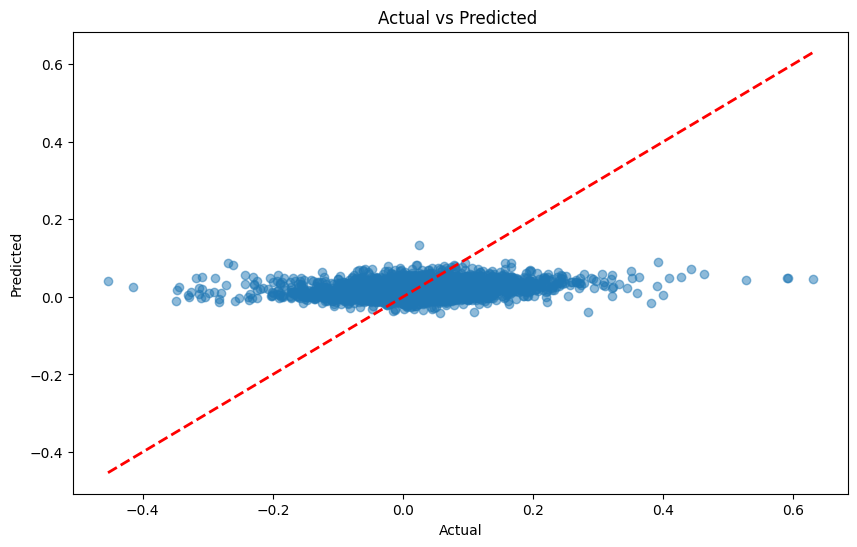

In [66]:
# Plotting Actual vs Predicted Night Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted ')
plt.show()

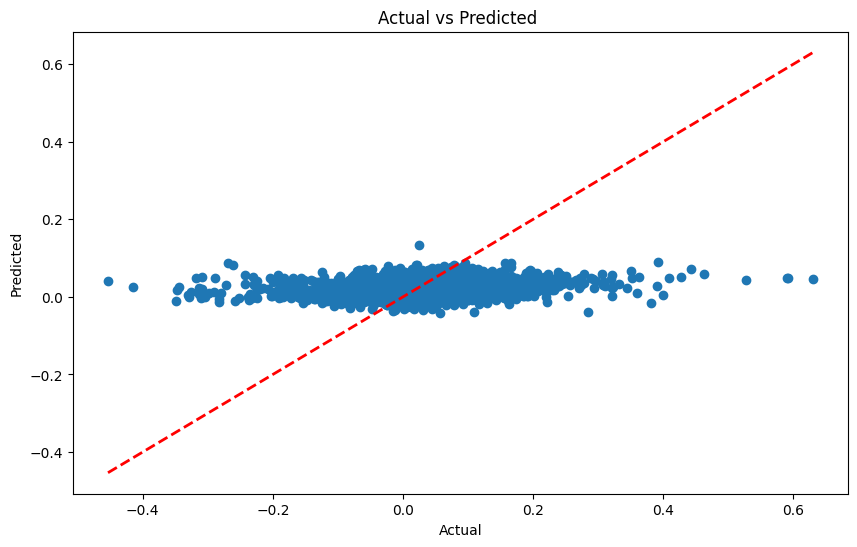

In [74]:
# Plotting Actual vs Predicted Night Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted ')
plt.show()

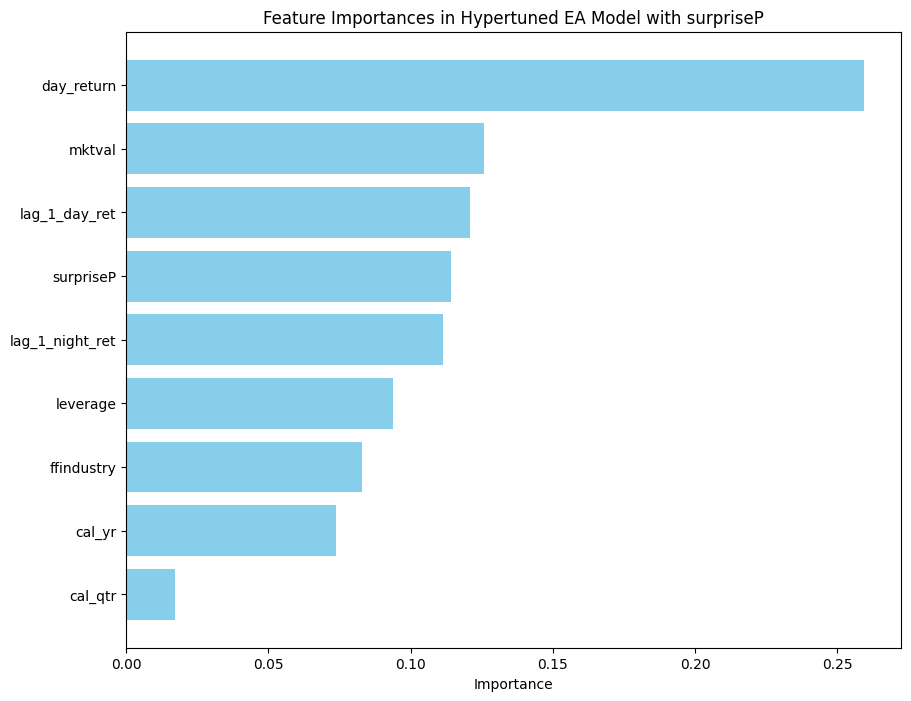

In [ ]:
# Saving feature importances
feature_importances_earnings = pd.DataFrame({
    'feature': X_earnings.columns,
    'importance': best_model_earnings.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort the features by importance
feature_importances_earnings = feature_importances_earnings.sort_values(by='importance', ascending=True)

# Plotting feature importances for the hypertuned EA model with `surpriseP`
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_earnings['feature'], feature_importances_earnings['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Hypertuned EA Model with surpriseP')
plt.show()

#### Hyperthuned EA Positive separating night returns and lead_1_day_ret

MSE for Night Return after hypertuning: 0.002936261622734093
MSE for Lead 1 Day Return after hypertuning: 0.0013585725779012628
R-squared for Night Return after hypertuning: 0.06759969272822197
R-squared for Lead 1 Day Return after hypertuning: 0.01067262374059108


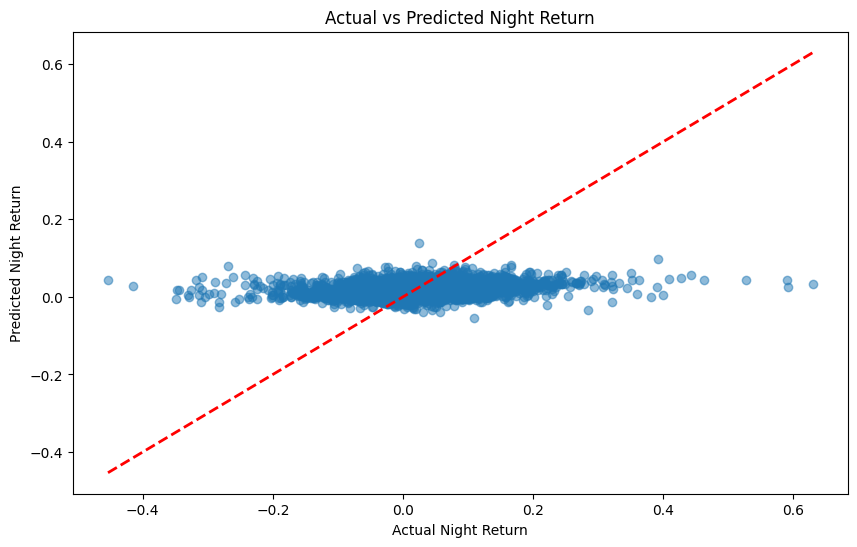

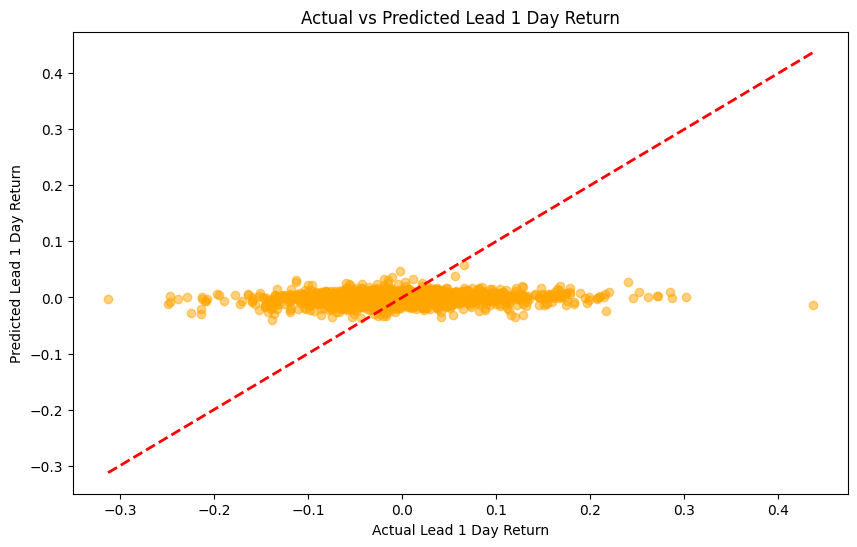

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Prepare datasets
X_earnings = data_surprise_positive[['day_return', 'lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'surpriseP', 'ffindustry', 'leverage', 'mktval', 'cal_qtr', 'cal_yr']]
y_earnings = data_surprise_positive[['night_return', 'lead_1_day_ret']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the best parameters found from the hypertuning step
best_params = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 150
}

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error for both target variables
mse_earnings_night = mean_squared_error(y_test['night_return'], predictions[:, 0])
mse_earnings_lead = mean_squared_error(y_test['lead_1_day_ret'], predictions[:, 1])
print(f'MSE for Night Return after hypertuning: {mse_earnings_night}')
print(f'MSE for Lead 1 Day Return after hypertuning: {mse_earnings_lead}')

# Calculate R-squared for both target variables
r2_earnings_night = r2_score(y_test['night_return'], predictions[:, 0])
r2_earnings_lead = r2_score(y_test['lead_1_day_ret'], predictions[:, 1])
print(f'R-squared for Night Return after hypertuning: {r2_earnings_night}')
print(f'R-squared for Lead 1 Day Return after hypertuning: {r2_earnings_lead}')

# Plotting Actual vs Predicted Night Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test['night_return'], predictions[:, 0], alpha=0.5)
plt.plot([y_test['night_return'].min(), y_test['night_return'].max()], 
         [y_test['night_return'].min(), y_test['night_return'].max()], 'r--', lw=2)
plt.xlabel('Actual Night Return')
plt.ylabel('Predicted Night Return')
plt.title('Actual vs Predicted Night Return')
plt.show()

# Plotting Actual vs Predicted Lead 1 Day Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test['lead_1_day_ret'], predictions[:, 1], alpha=0.5, color='orange')
plt.plot([y_test['lead_1_day_ret'].min(), y_test['lead_1_day_ret'].max()], 
         [y_test['lead_1_day_ret'].min(), y_test['lead_1_day_ret'].max()], 'r--', lw=2)
plt.xlabel('Actual Lead 1 Day Return')
plt.ylabel('Predicted Lead 1 Day Return')
plt.title('Actual vs Predicted Lead 1 Day Return')
plt.show()


#### Hyperthuned EA postive only NIGHT RETURN

c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE for Night Return after hypertuning: 0.0029296566487597535
R-squared for Night Return after hypertuning: 0.06969708068422487


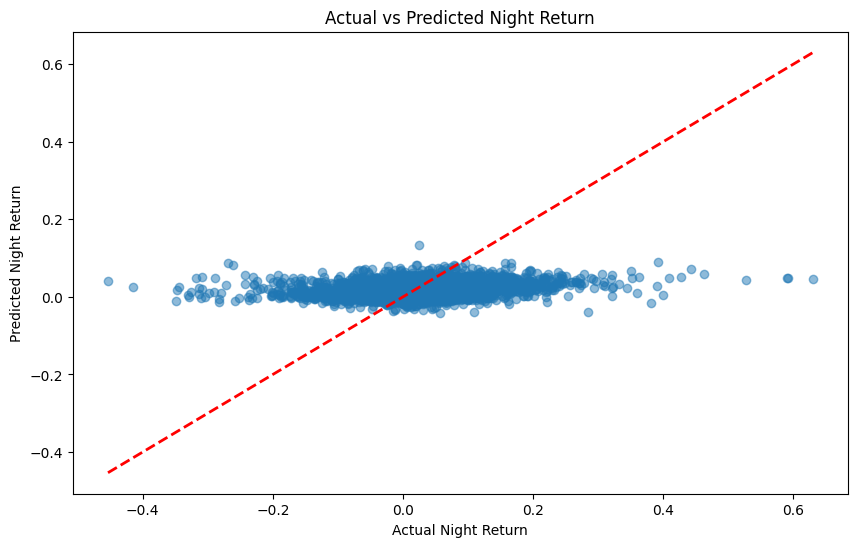

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Prepare datasets
X_earnings = data_surprise_positive[['day_return', 'lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'surpriseP', 'ffindustry', 'leverage', 'mktval', 'cal_qtr', 'cal_yr']]
y_earnings = data_surprise_positive[['night_return']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the best parameters found from the hypertuning step
best_params = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 150
}

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error for both target variables
mse_earnings_night = mean_squared_error(y_test['night_return'], predictions)
print(f'MSE for Night Return after hypertuning: {mse_earnings_night}')

# Calculate R-squared for both target variables
r2_earnings_night = r2_score(y_test['night_return'], predictions)
print(f'R-squared for Night Return after hypertuning: {r2_earnings_night}')

# Plotting Actual vs Predicted Night Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test['night_return'], predictions, alpha=0.5)
plt.plot([y_test['night_return'].min(), y_test['night_return'].max()], 
         [y_test['night_return'].min(), y_test['night_return'].max()], 'r--', lw=2)
plt.xlabel('Actual Night Return')
plt.ylabel('Predicted Night Return')
plt.title('Actual vs Predicted Night Return')
plt.show()




#### Hyperthuned EA postive only LEAD RET 1

c:\Users\gmarkari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE for Lead 1 Day Return after hypertuning: 0.0013589638154656476
R-squared for Lead 1 Day Return after hypertuning: 0.010387720276938794


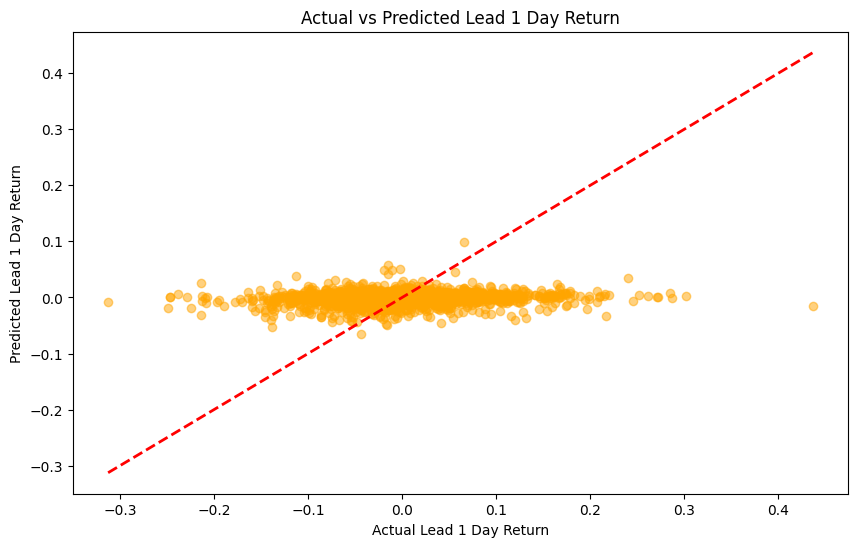

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Prepare datasets
X_earnings = data_surprise_positive[['day_return', 'lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'surpriseP', 'ffindustry', 'leverage', 'mktval', 'cal_qtr', 'cal_yr']]
y_earnings = data_surprise_positive[['lead_1_day_ret']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_earnings, y_earnings, test_size=0.2, random_state=42)

# Define the best parameters found from the hypertuning step
best_params = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 150
}

# Use the best parameters to train the model
best_model_earnings = RandomForestRegressor(**best_params, random_state=42)
best_model_earnings.fit(X_train, y_train)

# Make predictions
predictions = best_model_earnings.predict(X_test)

# Calculate the mean squared error for both target variables
mse_earnings_lead = mean_squared_error(y_test['lead_1_day_ret'], predictions)
print(f'MSE for Lead 1 Day Return after hypertuning: {mse_earnings_lead}')

# Calculate R-squared for both target variables
r2_earnings_lead = r2_score(y_test['lead_1_day_ret'], predictions)
print(f'R-squared for Lead 1 Day Return after hypertuning: {r2_earnings_lead}')


# Plotting Actual vs Predicted Lead 1 Day Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test['lead_1_day_ret'], predictions, alpha=0.5, color='orange')
plt.plot([y_test['lead_1_day_ret'].min(), y_test['lead_1_day_ret'].max()], 
         [y_test['lead_1_day_ret'].min(), y_test['lead_1_day_ret'].max()], 'r--', lw=2)
plt.xlabel('Actual Lead 1 Day Return')
plt.ylabel('Predicted Lead 1 Day Return')
plt.title('Actual vs Predicted Lead 1 Day Return')
plt.show()


### Concat the results

In [ ]:
# create a new data based with all the results final
results_final = pd.concat([results_non_ea,results_ea_without_surpriseP,results_ea_with_surpriseP,results_ea_with_surpriseP_with_variables,results_ea_with_surpriseP_positve,results_ea_with_surpriseP_negative,results_hypethuned_EA_positive])


In [ ]:
#save the results
#results_final.to_csv(r"C:\Users\gmarkari\Desktop\EA earnings Full folder\Project DataScience\results_final_random_forest4.csv", index = False)

### GRAPH to compare models

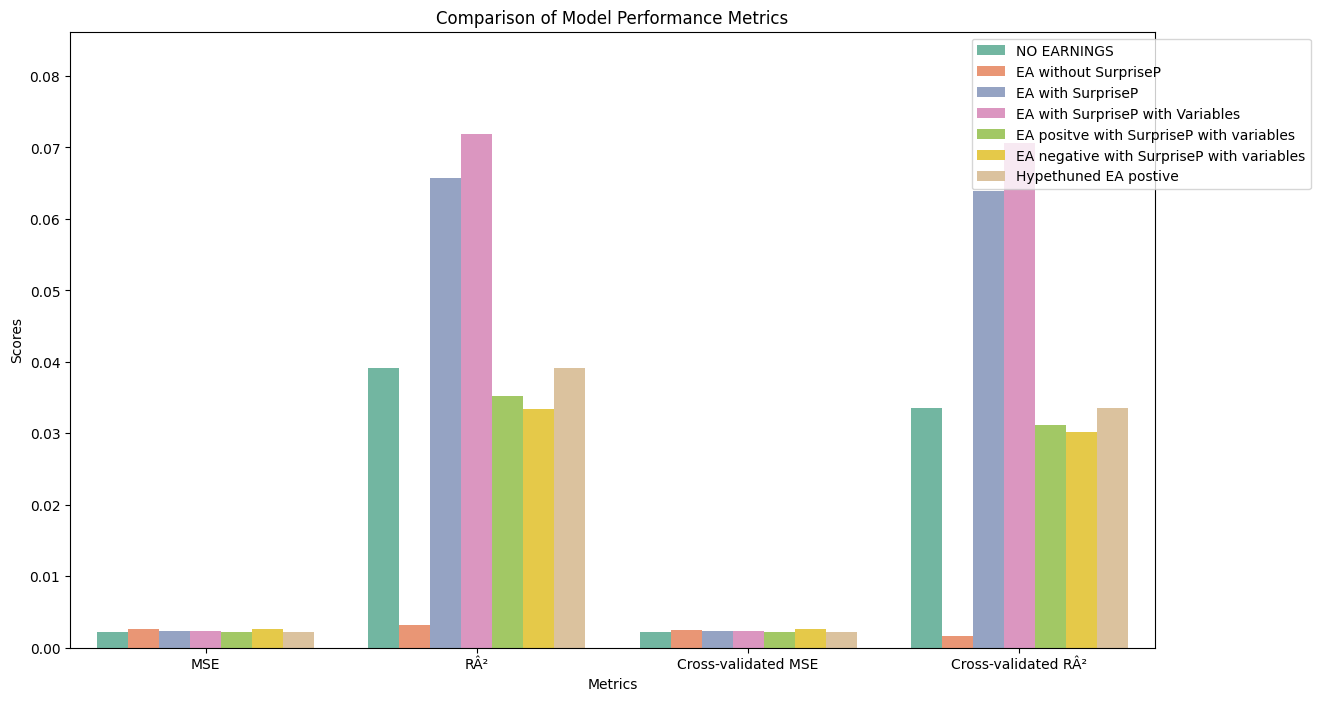

In [83]:
# read excel
results_final = pd.read_excel(r"C:\Users\gmarkari\Desktop\EA earnings Full folder\Project DataScience\results_final_random_forest44.xlsx")

# Melt the DataFrame for easier plotting with Seaborn
results_melted = results_final.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting with Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=results_melted, palette='Set2')

# Adding labels and title
plt.title('Comparison of Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.ylim(0, max(results_melted['Score']) * 1.2)

# Adjust legend
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.show()

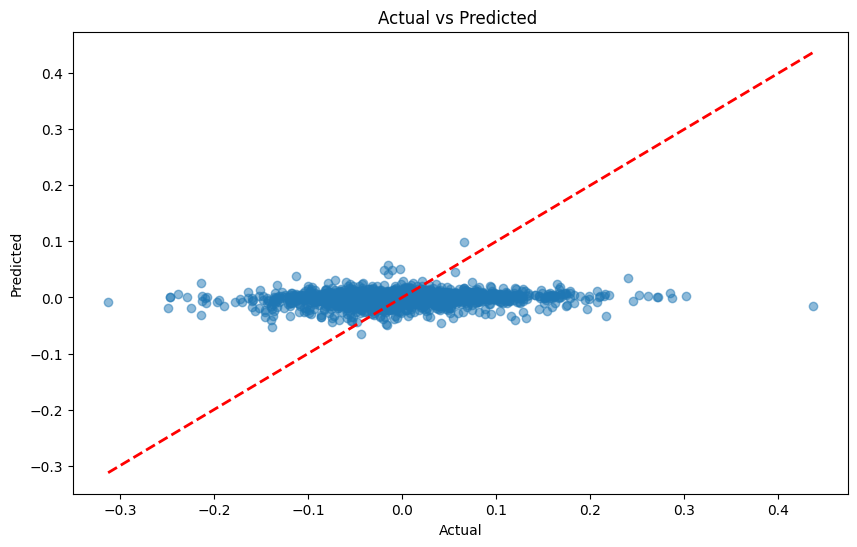

In [81]:
# Plotting Actual vs Predicted Night Return
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted ')
plt.show()

### Previous Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

# Assuming `data` is your DataFrame

X = merged_data[['day_return','lag_1_day_ret', 'lag_1_night_ret', 'lag_2_day_ret', 'lag_2_night_ret', 'surpriseP']]

y = merged_data['night_return']

# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model

#model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

# Predict on the test set

predictions = model.predict(X_test)

# Evaluate the model

mse = mean_squared_error(y_test, predictions)

print(f'Mean Squared Error: {mse}')

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Create a DataFrame with predictions and actual values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})

# Save to CSV
results_df.to_csv(r"C:\Users\gmarkari\Desktop\EA earnings Full folder\Project DataScience\results_randomforest.csv", index=False)



In [ ]:
with open(r"C:\Users\gmarkari\Desktop\EA earnings Full folder\Project DataScience\results_randomforest.txt", 'w') as file:
    file.write(f'Mean Squared Error: {mse}\n')


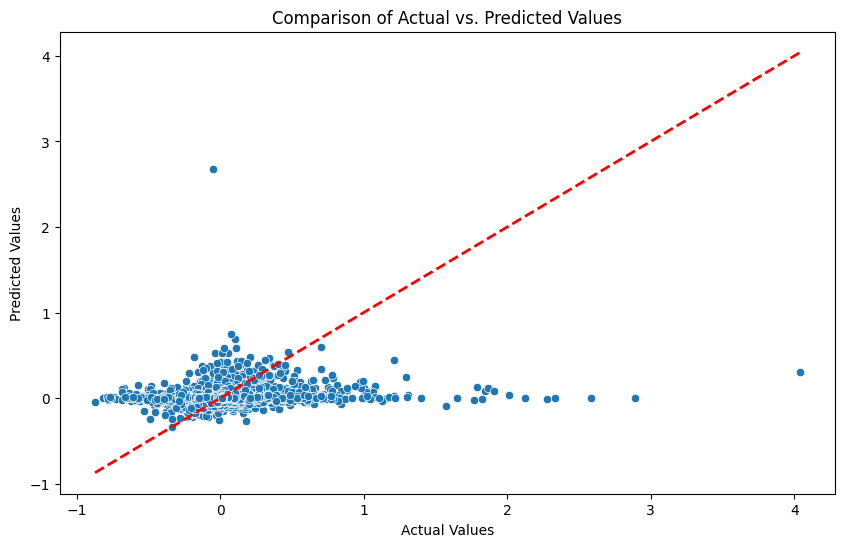

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)
plt.title('Comparison of Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Diagonal line
plt.show()


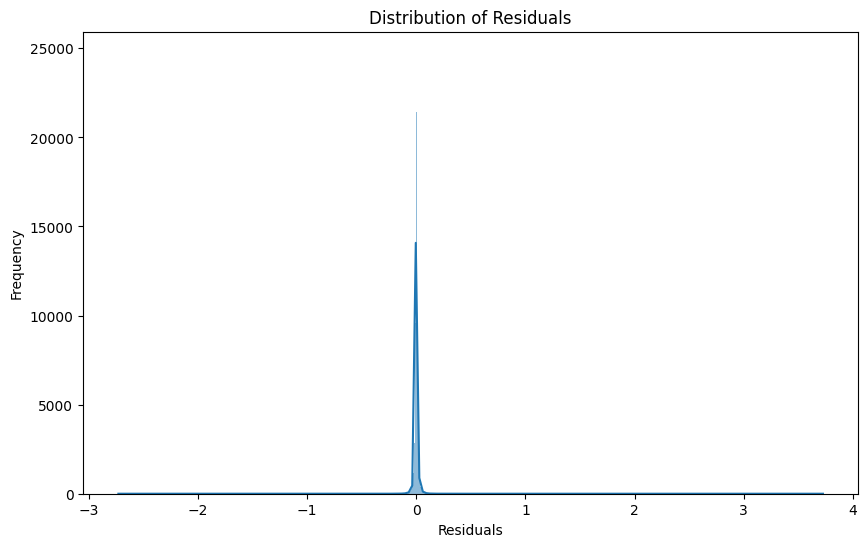

In [ ]:
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd

# Load the feature importances from CSV
feature_importances = pd.read_csv(r"C:\Users\gmarkari\Desktop\EA earnings Full folder\Project DataScience\results_randomforest.csv")


In [ ]:
import matplotlib.pyplot as plt

# Assuming the file has columns 'Unnamed: 0' for features and 'Importance' for their importances
feature_importances.sort_values(by='Importance', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Unnamed: 0'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from RandomForest Model')
plt.show()


KeyError: 'Importance'

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Assuming non_earnings_data is loaded and contains the necessary columns

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
X_non_earnings_scaled = scaler.fit_transform(non_earnings_data[['day_return', 'lag_1_day_ret', 'lag_1_night_ret']])
y_non_earnings_scaled = scaler.fit_transform(non_earnings_data[['night_return', 'lead_1_day_ret']])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_non_earnings_scaled, y_non_earnings_scaled, test_size=0.2, random_state=42)

# LSTM expects [samples, time steps, features], adding time steps dimension (assuming each sample is a timestep)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2))  # predicting two outputs

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Invert scaling

# Calculate MSE
mse = tf.reduce_mean(tf.square(predictions - scaler.inverse_transform(y_test))).numpy()

print(f'MSE for Non-Earnings Days: {mse}')